# Manning liveProject Beta-testing START: Time Series Forecasting with Bayesian Modeling Techniques

## 1. Data Manipulation: Forming a Weekly Time Series

In [1]:
%matplotlib inline

In [2]:
import os

import pandas as pd

In [3]:
bookings_file = os.path.join('data', 'H1.csv')
df = pd.read_csv(bookings_file)

In [4]:
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate'],
      dtype='object')

In [6]:
df.shape

(40060, 31)

In [7]:
# Check for nulls
len(df) - df.count()

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                           0
Children                         0
Babies                           0
Meal                             0
Country                        464
MarketSegment                    0
DistributionChannel              0
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                      0
Agent                            0
Company                          0
DaysInWaitingList                0
CustomerType                     0
ADR                              0
RequiredCarParkingSpaces         0
TotalOfSpecialReques

In [8]:
df['ArrivalDateYear'].value_counts()

2016    18567
2017    13179
2015     8314
Name: ArrivalDateYear, dtype: int64

In [9]:
# Join year and week columns YYYYVV
# Note the weeks need zero padding
df['yr_week'] = df[['ArrivalDateYear', 'ArrivalDateWeekNumber']].apply(lambda x: str(x[0]) + str(x[1]).zfill(2), axis=1)

In [10]:
df_week_counts = df.groupby('yr_week')['IsCanceled']\
    .sum()\
    .reset_index()\
    .sort_values('yr_week')\
    .rename(columns={'yr_week': 'Date (Year and Week Number)'})\
    .set_index('Date (Year and Week Number)')

In [11]:
df_week_counts.head()

,IsCanceled
Date (Year and Week Number),
201527,41
201528,48
201529,87
201530,74
201531,101


## 2. Time Series Components

Decomposition of the time series, and plots of the trend, residual, and seasonal components  
https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [13]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,8)

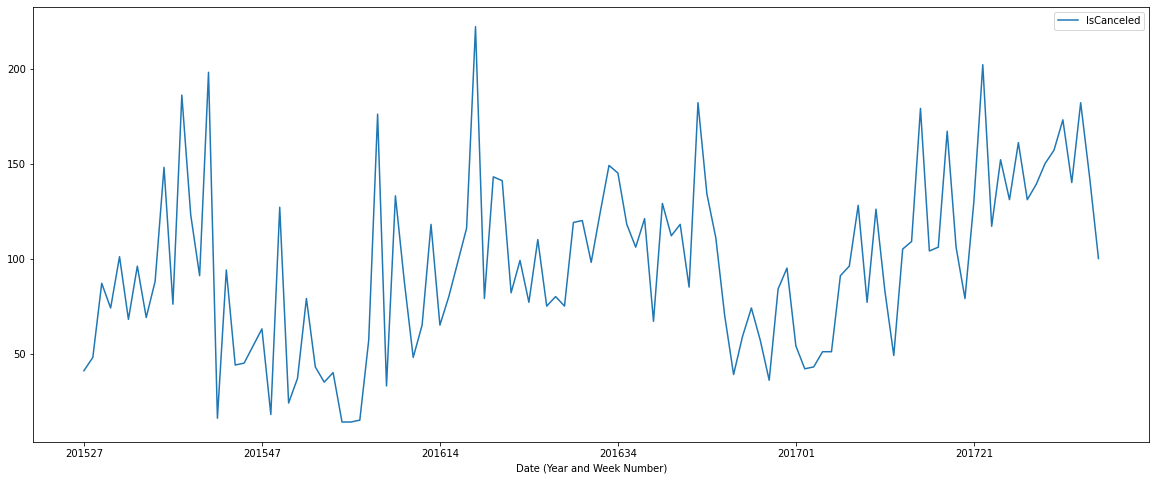

In [14]:
df_week_counts.plot();

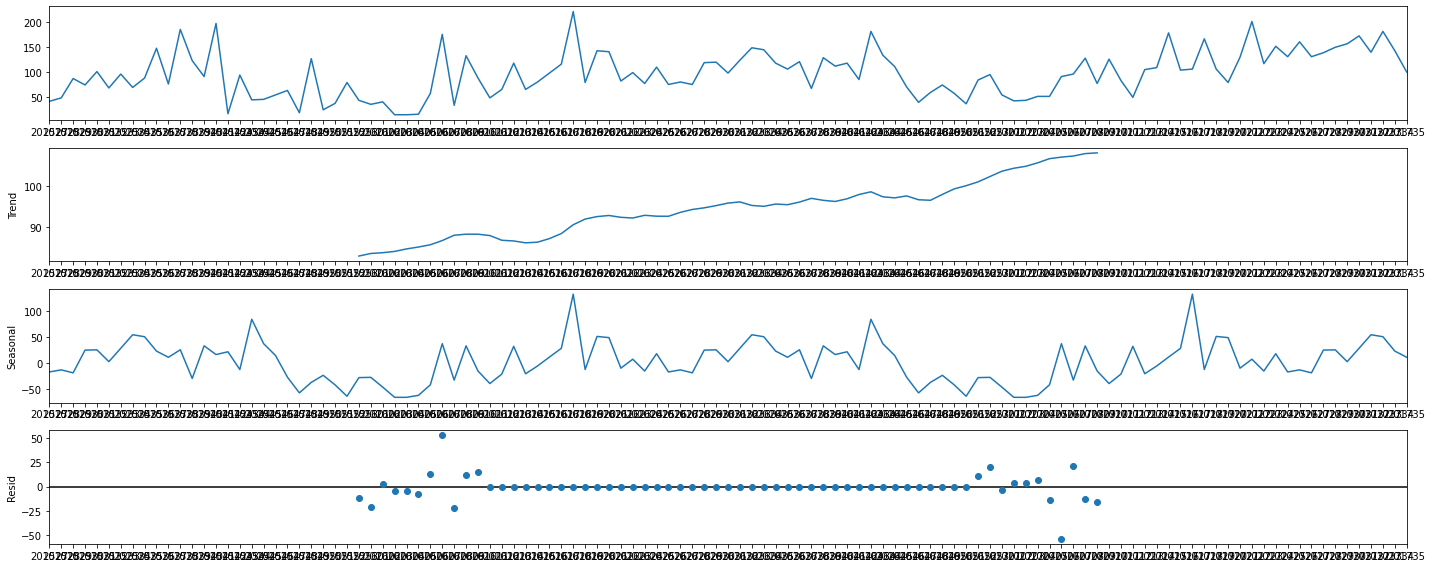

In [15]:
result = seasonal_decompose(df_week_counts, model='additive', period=52);
result.plot();

Autocorrelation and partial autocorrelation plots of the time series

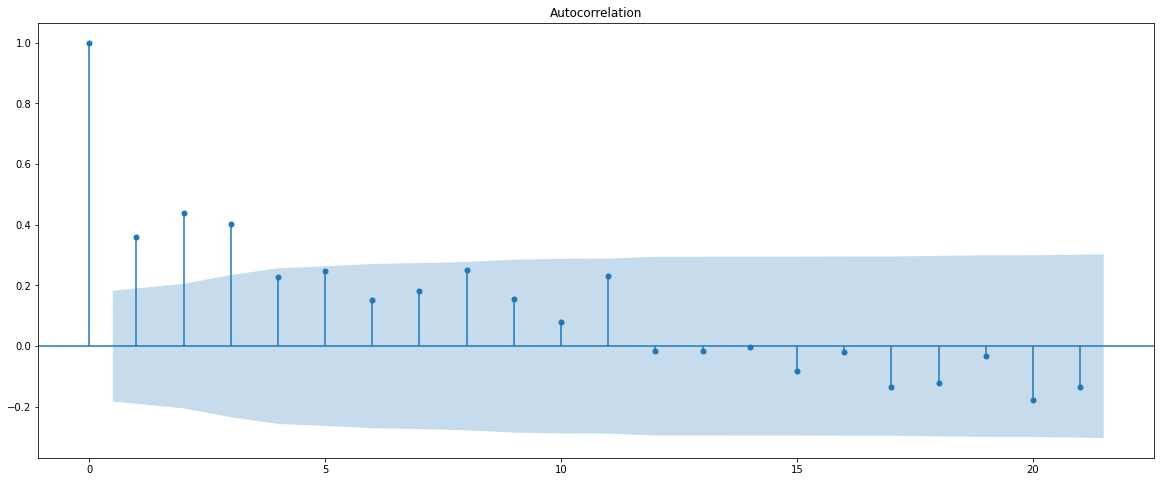

In [16]:
plot_acf(df_week_counts);

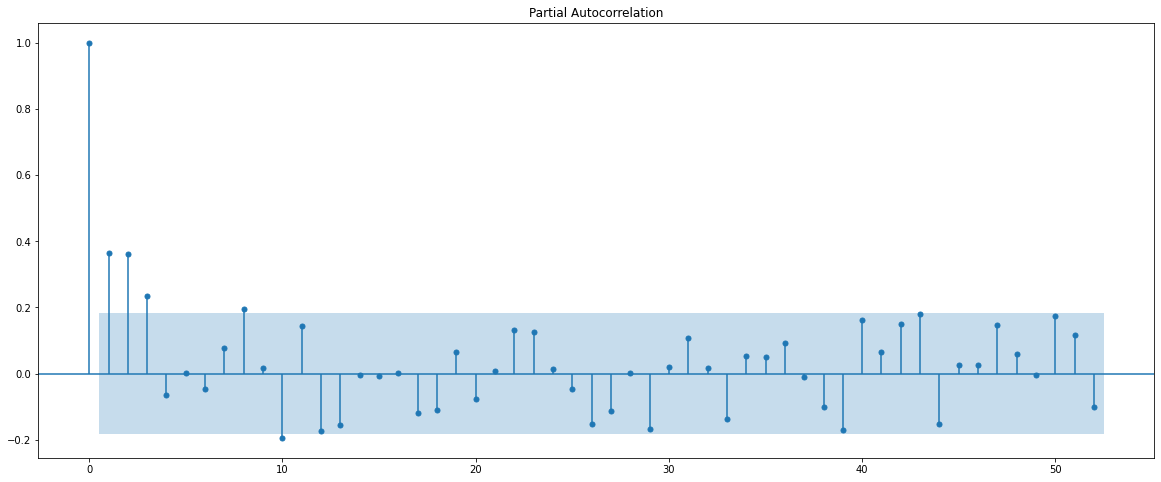

In [17]:
plot_pacf(df_week_counts, lags=52);

A 4-period SMA plotted against the actual time series

In [18]:
df_week_counts['MvAvg'] = df_week_counts['IsCanceled'].rolling(4, min_periods=1).mean()

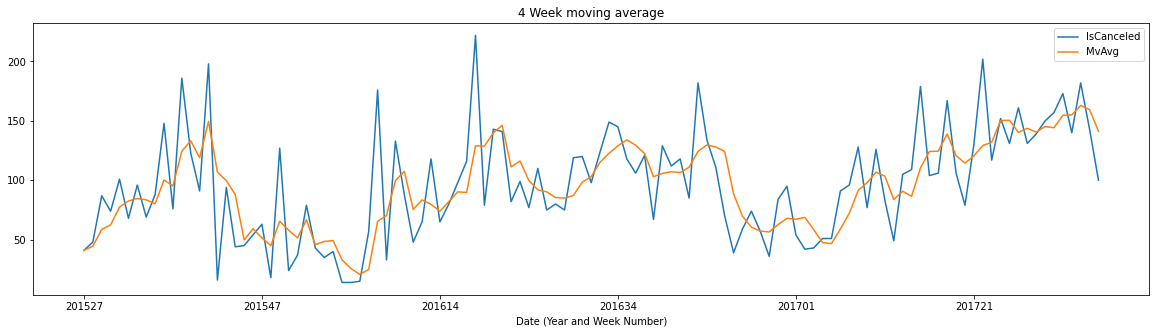

In [19]:
df_week_counts.plot(figsize = (20,5), title="4 Week moving average");

90/10 train-test split

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
df_week_counts.shape

(115, 2)

In [22]:
train, test = train_test_split(df_week_counts['IsCanceled'], test_size=0.1, shuffle=False)

In [23]:
train.size

103

In [24]:
test.size

12

In [25]:
train.index.min(), train.index.max()

('201527', '201723')

In [26]:
test.index.min(), test.index.max()

('201724', '201735')

## 3. Forecasting Weekly Hotel Cancellations with an ARIMA Model

Workflow

1. Use pmdarima to train a model on the training data and select a model of best fit based on the Bayesian Information Criterion (BIC). 
The lower the BIC, the higher the fit. Make sure to identify an appropriate seasonal factor when configuring the model (Hint: Use the autocorrelation function to aid you in doing this).

2. Calculate the root mean squared error for the predictions versus the actual number of cancellations in the test set. Compare the RMSE value to the mean number of cancellations across the test set.

The deliverable for this project is a Jupyter Notebook outlining the following:

1. Configuration of an ARIMA model using pmdarima, with the model of best fit ranked according to the Bayesian Information Criterion (BIC).
2. Calculation of model accuracy against the test set using RMSE.

https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

In [27]:
import pmdarima as pm
import numpy as np
from sklearn.metrics import mean_squared_error
# from pmdarima import model_selection

In [28]:
# test for stationarity
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(train)

(0.14312532706082925, True)

Data has stationarity

In [40]:
# Fit an auto_arima model
model = pm.auto_arima(
    train, 
    d=0,
    max_p=5,
    max_d=5,
    max_q=5,
    seasonal=True,
    error_action='warn',
    trace=True,
    information_criterion='bic')

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=1077.741, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=1082.145, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=1079.308, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=1081.961, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=1247.831, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=1074.056, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=1078.950, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=1074.322, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : BIC=1077.012, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : BIC=1073.885, Time=0.06 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : BIC=1077.693, Time=0.12 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : BIC=1081.438, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : BIC=1143.383, Time=0.07 sec

Best model:  ARIMA(0,0,3)(0,0,0)[0] intercept
Total fit time: 0.957 seconds


In [41]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  103
Model:               SARIMAX(0, 0, 3)   Log Likelihood                -525.356
Date:                Thu, 18 Feb 2021   AIC                           1060.711
Time:                        22:15:46   BIC                           1073.885
Sample:                             0   HQIC                          1066.047
                                - 103                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     91.1712      7.745     11.771      0.000      75.991     106.352
ma.L1          0.1149      0.098      1.169      0.243      -0.078       0.308
ma.L2          0.2728      0.128      2.138      0.032       0.023       0.523
ma.L3          0.3368      0.120      2.798      0.005       0.101       0.573
sigma2      1569.1379    204.962      7.656      0.000    1167.421    1970.855
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                15.94
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.82
Prob(H) (two-sided):                  0.60   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)

In [43]:
rmse = np.sqrt(mean_squared_error(test, preds))
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 55.14


In [44]:
df_week_counts['IsCanceled'].mean()

96.71304347826087

The error is quite high. The model is out by about 57% on average.